<a href="https://colab.research.google.com/github/Saoudyahya/-RL-based-edge-detection-system/blob/main/rl_operators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔍 RL-BASED EDGE DETECTION - FINDING OPTIMAL PIPELINE

📥 Loading images...
   Image: /content/test/airplaitest.jpeg
   Ground truth: /content/gt/airplane.jpg
   ✓ Loaded successfully (size: (321, 481))

🎯 RL Configuration:
   Episodes: 500
   Reward metric: iou
   Search space: 6 × 6 × 7 = 252 combinations

🚀 Starting exploration...
--------------------------------------------------------------------------------
   Episode  100/500 | Avg Reward: 0.1813 | Best Reward: 0.3788 | Epsilon: 0.6058
   Episode  200/500 | Avg Reward: 0.2441 | Best Reward: 0.3948 | Epsilon: 0.3670
   Episode  300/500 | Avg Reward: 0.2519 | Best Reward: 0.3948 | Epsilon: 0.2223
   Episode  400/500 | Avg Reward: 0.3051 | Best Reward: 0.3948 | Epsilon: 0.1347
   Episode  500/500 | Avg Reward: 0.3262 | Best Reward: 0.3948 | Epsilon: 0.0816
--------------------------------------------------------------------------------
✅ Exploration completed!

📊 BEST PIPELINE FOUND

🔧 Optimal Pipeline:
   Preprocessing   → histogra

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


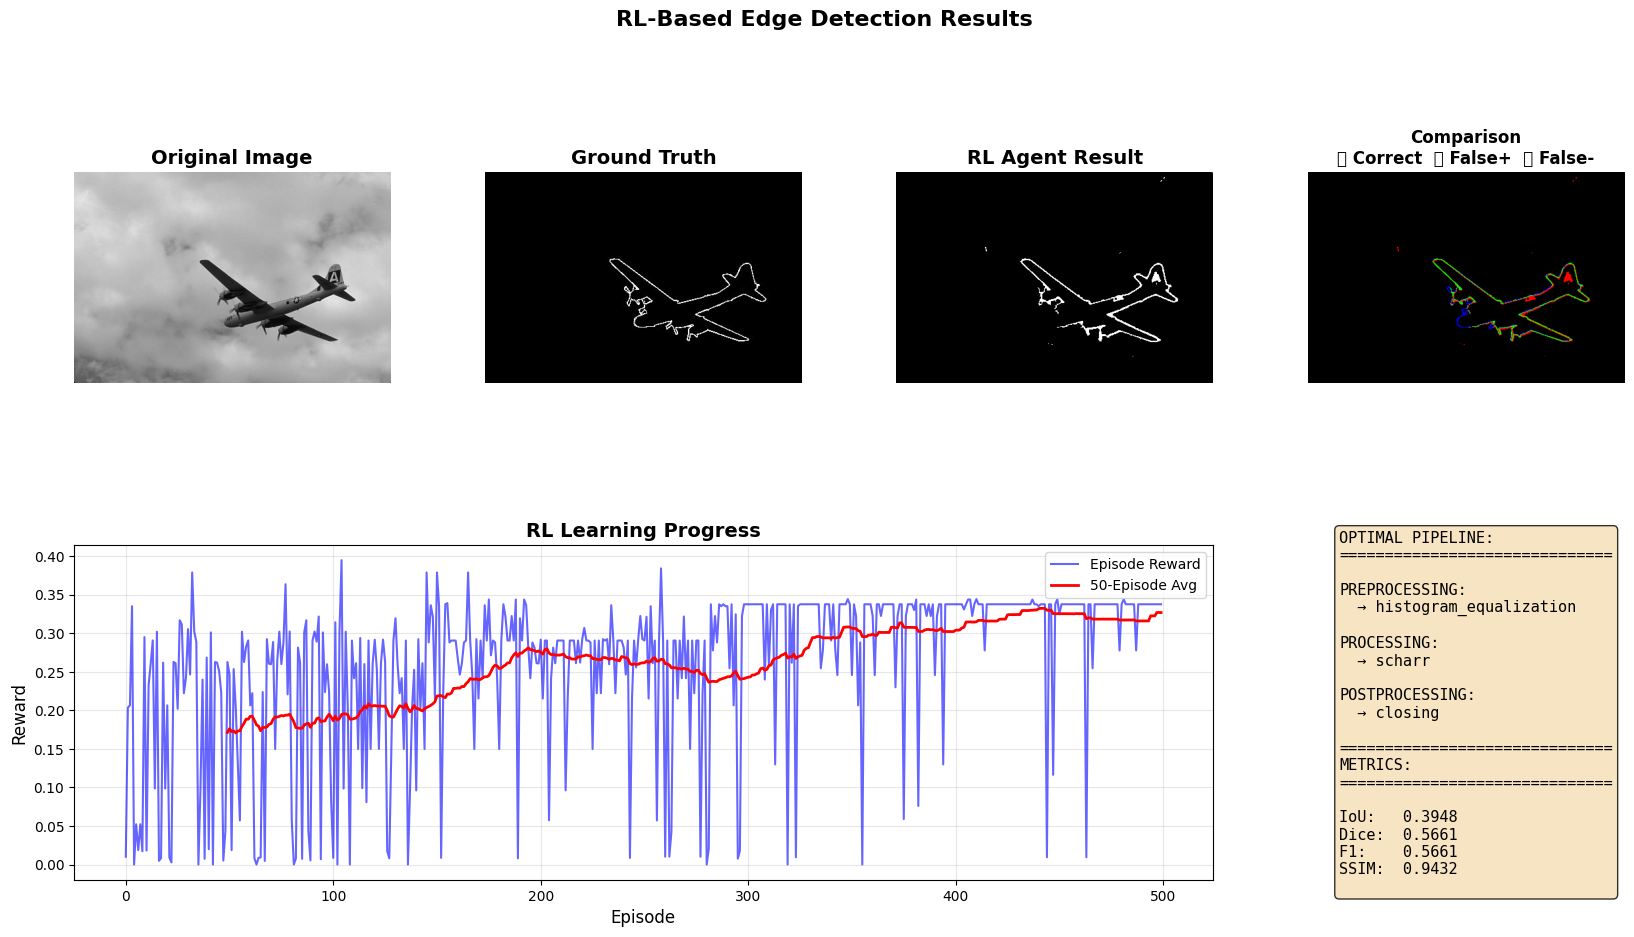

In [ ]:
"""
RL-Based Edge Detection Pipeline Optimizer - CORRECT VERSION
============================================================

Input: ONE original image + ONE ground truth
Output: Best edge detection pipeline for THAT image
"""

import numpy as np
import cv2
import pickle
from collections import defaultdict
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


# ============================================================================
# OPERATORS
# ============================================================================

class PreprocessingOperators:
    @staticmethod
    def gaussian_blur(image, kernel_size=5):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    @staticmethod
    def median_filter(image, kernel_size=5):
        return cv2.medianBlur(image, kernel_size)

    @staticmethod
    def histogram_equalization(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.equalizeHist(image)

    @staticmethod
    def bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
        return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

    @staticmethod
    def normalization(image):
        return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    @staticmethod
    def no_preprocessing(image):
        return image.copy()


class ProcessingOperators:
    @staticmethod
    def sobel(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def prewitt(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        grad_x = cv2.filter2D(image.astype(float), -1, kernel_x)
        grad_y = cv2.filter2D(image.astype(float), -1, kernel_y)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def scharr(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def laplacian(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=3)
        laplacian = np.abs(laplacian)
        laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(laplacian, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def canny(image, threshold1=50, threshold2=150):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.Canny(image, threshold1, threshold2)

    @staticmethod
    def canny_adaptive(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        median = np.median(image)
        sigma = 0.33
        lower = int(max(0, (1.0 - sigma) * median))
        upper = int(min(255, (1.0 + sigma) * median))
        return cv2.Canny(image, lower, upper)


class PostprocessingOperators:
    @staticmethod
    def dilation(image, kernel_size=3, iterations=1):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.dilate(image, kernel, iterations=iterations)

    @staticmethod
    def erosion(image, kernel_size=3, iterations=1):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.erode(image, kernel, iterations=iterations)

    @staticmethod
    def opening(image, kernel_size=3):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    @staticmethod
    def closing(image, kernel_size=3):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    @staticmethod
    def adaptive_threshold(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

    @staticmethod
    def non_maximum_suppression(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
        return gradient

    @staticmethod
    def no_postprocessing(image):
        return image.copy()


PREPROCESSING_OPS = {
    0: ('gaussian_blur', PreprocessingOperators.gaussian_blur),
    1: ('median_filter', PreprocessingOperators.median_filter),
    2: ('histogram_equalization', PreprocessingOperators.histogram_equalization),
    3: ('bilateral_filter', PreprocessingOperators.bilateral_filter),
    4: ('normalization', PreprocessingOperators.normalization),
    5: ('no_preprocessing', PreprocessingOperators.no_preprocessing),
}

PROCESSING_OPS = {
    0: ('sobel', ProcessingOperators.sobel),
    1: ('prewitt', ProcessingOperators.prewitt),
    2: ('scharr', ProcessingOperators.scharr),
    3: ('laplacian', ProcessingOperators.laplacian),
    4: ('canny', ProcessingOperators.canny),
    5: ('canny_adaptive', ProcessingOperators.canny_adaptive),
}

POSTPROCESSING_OPS = {
    0: ('dilation', PostprocessingOperators.dilation),
    1: ('erosion', PostprocessingOperators.erosion),
    2: ('opening', PostprocessingOperators.opening),
    3: ('closing', PostprocessingOperators.closing),
    4: ('adaptive_threshold', PostprocessingOperators.adaptive_threshold),
    5: ('non_maximum_suppression', PostprocessingOperators.non_maximum_suppression),
    6: ('no_postprocessing', PostprocessingOperators.no_postprocessing),
}


# ============================================================================
# METRICS
# ============================================================================

def intersection_over_union(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union if union > 0 else 0.0


def dice_coefficient(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    return 2.0 * intersection / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 0.0


def f1_score(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    true_positive = np.logical_and(pred == 1, gt == 1).sum()
    false_positive = np.logical_and(pred == 1, gt == 0).sum()
    false_negative = np.logical_and(pred == 0, gt == 1).sum()
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0


def ssim_score(pred, gt):
    if pred.shape != gt.shape:
        return 0.0
    if len(pred.shape) == 3:
        pred = pred[:, :, 0]
    if len(gt.shape) == 3:
        gt = gt[:, :, 0]
    return ssim(pred, gt, data_range=255)


def compute_reward(pred, gt, metric='iou'):
    if metric == 'iou':
        return intersection_over_union(pred, gt)
    elif metric == 'dice':
        return dice_coefficient(pred, gt)
    elif metric == 'f1':
        return f1_score(pred, gt)
    elif metric == 'ssim':
        return (ssim_score(pred, gt) + 1) / 2
    else:
        return intersection_over_union(pred, gt)


# ============================================================================
# MAIN RL FUNCTION
# ============================================================================

def find_best_pipeline(image_path, ground_truth_path, episodes=500,
                       reward_metric='iou', save_result=None):
    """
    Find the optimal edge detection pipeline for a single image using RL.

    Args:
        image_path: Path to the original image
        ground_truth_path: Path to the ground truth edge map
        episodes: Number of episodes to explore (default: 500)
        reward_metric: Metric to optimize ('iou', 'dice', 'f1', 'ssim')
        save_result: Path to save the best result (optional)

    Returns:
        Dictionary with best pipeline and results

    Example:
        result = find_best_pipeline(
            image_path='/path/to/image.jpg',
            ground_truth_path='/path/to/ground_truth.png',
            episodes=500
        )
    """

    print("\n" + "="*80)
    print("🔍 RL-BASED EDGE DETECTION - FINDING OPTIMAL PIPELINE")
    print("="*80)

    # Load images
    print(f"\n📥 Loading images...")
    print(f"   Image: {image_path}")
    print(f"   Ground truth: {ground_truth_path}")

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"❌ Could not load image: {image_path}")

    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    if ground_truth is None:
        raise ValueError(f"❌ Could not load ground truth: {ground_truth_path}")

    if image.shape != ground_truth.shape:
        ground_truth = cv2.resize(ground_truth, (image.shape[1], image.shape[0]))

    print(f"   ✓ Loaded successfully (size: {image.shape})")

    # Q-Learning setup
    print(f"\n🎯 RL Configuration:")
    print(f"   Episodes: {episodes}")
    print(f"   Reward metric: {reward_metric}")
    print(f"   Search space: {len(PREPROCESSING_OPS)} × {len(PROCESSING_OPS)} × {len(POSTPROCESSING_OPS)} = {len(PREPROCESSING_OPS) * len(PROCESSING_OPS) * len(POSTPROCESSING_OPS)} combinations")

    q_table = defaultdict(lambda: defaultdict(float))
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    learning_rate = 0.1
    discount_factor = 0.95

    best_reward = -float('inf')
    best_pipeline = None
    best_result = None
    history = []

    print(f"\n🚀 Starting exploration...")
    print("-"*80)

    # RL exploration
    for episode in range(episodes):
        # Reset
        current_img = image.copy()
        pipeline = {}
        total_reward = 0

        # Phase 1: Preprocessing
        state = 0
        if np.random.random() < epsilon:
            action = np.random.randint(0, len(PREPROCESSING_OPS))
        else:
            q_values = [q_table[state][a] for a in range(len(PREPROCESSING_OPS))]
            action = np.argmax(q_values)

        op_name, op_func = PREPROCESSING_OPS[action]
        current_img = op_func(current_img)
        pipeline['preprocessing'] = (action, op_name)

        # Phase 2: Processing (Edge Detection)
        state = 1
        if np.random.random() < epsilon:
            action = np.random.randint(0, len(PROCESSING_OPS))
        else:
            q_values = [q_table[state][a] for a in range(len(PROCESSING_OPS))]
            action = np.argmax(q_values)

        op_name, op_func = PROCESSING_OPS[action]
        current_img = op_func(current_img)
        pipeline['processing'] = (action, op_name)

        # Phase 3: Postprocessing
        state = 2
        if np.random.random() < epsilon:
            action = np.random.randint(0, len(POSTPROCESSING_OPS))
        else:
            q_values = [q_table[state][a] for a in range(len(POSTPROCESSING_OPS))]
            action = np.argmax(q_values)

        op_name, op_func = POSTPROCESSING_OPS[action]
        current_img = op_func(current_img)
        pipeline['postprocessing'] = (action, op_name)

        # Compute reward
        reward = compute_reward(current_img, ground_truth, metric=reward_metric)

        # Update Q-values
        for phase_idx, phase_name in enumerate(['preprocessing', 'processing', 'postprocessing']):
            action_taken = pipeline[phase_name][0]
            q_table[phase_idx][action_taken] = q_table[phase_idx][action_taken] + \
                learning_rate * (reward - q_table[phase_idx][action_taken])

        # Track best
        if reward > best_reward:
            best_reward = reward
            best_pipeline = pipeline.copy()
            best_result = current_img.copy()

        history.append(reward)

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(history[-100:])
            print(f"   Episode {episode + 1:4d}/{episodes} | "
                  f"Avg Reward: {avg_reward:.4f} | "
                  f"Best Reward: {best_reward:.4f} | "
                  f"Epsilon: {epsilon:.4f}")

    print("-"*80)
    print("✅ Exploration completed!\n")

    # Compute final metrics
    metrics = {
        'iou': intersection_over_union(best_result, ground_truth),
        'dice': dice_coefficient(best_result, ground_truth),
        'f1': f1_score(best_result, ground_truth),
        'ssim': ssim_score(best_result, ground_truth),
    }

    print("="*80)
    print("📊 BEST PIPELINE FOUND")
    print("="*80)
    print(f"\n🔧 Optimal Pipeline:")
    for phase, (idx, name) in best_pipeline.items():
        print(f"   {phase.capitalize():15s} → {name}")

    print(f"\n📈 Performance Metrics:")
    print(f"   IoU:        {metrics['iou']:.4f}")
    print(f"   Dice:       {metrics['dice']:.4f}")
    print(f"   F1 Score:   {metrics['f1']:.4f}")
    print(f"   SSIM:       {metrics['ssim']:.4f}")
    print("="*80 + "\n")

    # Save result
    if save_result:
        cv2.imwrite(save_result, best_result)
        print(f"💾 Result saved to: {save_result}\n")

    # Visualize
    visualize_comparison(image, ground_truth, best_result, metrics, best_pipeline, history)

    return {
        'pipeline': best_pipeline,
        'result': best_result,
        'metrics': metrics,
        'reward_history': history,
        'best_reward': best_reward
    }


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_comparison(original, ground_truth, predicted, metrics, pipeline, history):
    """Create comprehensive visualization"""
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

    # Row 1: Images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(ground_truth, cmap='gray')
    ax2.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(predicted, cmap='gray')
    ax3.set_title('RL Agent Result', fontsize=14, fontweight='bold')
    ax3.axis('off')

    # Comparison overlay
    gt_binary = (ground_truth > 127).astype(np.uint8)
    pred_binary = (predicted > 127).astype(np.uint8)
    overlay = np.zeros((*original.shape, 3), dtype=np.uint8)
    overlay[..., 1] = np.logical_and(pred_binary, gt_binary).astype(np.uint8) * 255  # Green
    overlay[..., 0] = np.logical_and(pred_binary, ~gt_binary.astype(bool)).astype(np.uint8) * 255  # Red
    overlay[..., 2] = np.logical_and(~pred_binary.astype(bool), gt_binary).astype(np.uint8) * 255  # Blue

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(overlay)
    ax4.set_title('Comparison\n🟢 Correct  🔴 False+  🔵 False-', fontsize=12, fontweight='bold')
    ax4.axis('off')

    # Row 2: Learning curve and metrics
    ax5 = fig.add_subplot(gs[1, :3])
    episodes = list(range(len(history)))
    ax5.plot(episodes, history, alpha=0.6, color='blue', label='Episode Reward')

    # Moving average
    window = 50
    if len(history) >= window:
        moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
        ax5.plot(episodes[window-1:], moving_avg, 'r-', linewidth=2, label=f'{window}-Episode Avg')

    ax5.set_xlabel('Episode', fontsize=12)
    ax5.set_ylabel('Reward', fontsize=12)
    ax5.set_title('RL Learning Progress', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Pipeline and metrics info
    ax6 = fig.add_subplot(gs[1, 3])
    ax6.axis('off')

    info_text = "OPTIMAL PIPELINE:\n" + "="*30 + "\n\n"
    for phase, (idx, name) in pipeline.items():
        info_text += f"{phase.upper()}:\n  → {name}\n\n"

    info_text += "="*30 + "\n"
    info_text += "METRICS:\n" + "="*30 + "\n\n"
    info_text += f"IoU:   {metrics['iou']:.4f}\n"
    info_text += f"Dice:  {metrics['dice']:.4f}\n"
    info_text += f"F1:    {metrics['f1']:.4f}\n"
    info_text += f"SSIM:  {metrics['ssim']:.4f}\n"

    ax6.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.suptitle('RL-Based Edge Detection Results', fontsize=16, fontweight='bold', y=0.98)
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":


 result = find_best_pipeline(
    image_path='/content/test/airplaitest.jpeg',
    ground_truth_path='/content/gt/airplane.jpg',
    episodes=500,
    reward_metric='iou',
    save_result='best_result.png'
)




🔍 RL-BASED EDGE DETECTION - FINDING OPTIMAL PIPELINE

📥 Loading images...
   Image: /content/test/xhettah.jpeg
   Ground truth: /content/gt/chetah.jpg
   ✓ Loaded successfully (size: (160, 240))

🎯 RL Configuration:
   Episodes: 500
   Reward metric: f1
   Search space: 6 × 6 × 7 = 252 combinations

🚀 Starting exploration...
--------------------------------------------------------------------------------
   Episode  100/500 | Avg Reward: 0.1300 | Best Reward: 0.2869 | Epsilon: 0.6058
   Episode  200/500 | Avg Reward: 0.1770 | Best Reward: 0.2869 | Epsilon: 0.3670
   Episode  300/500 | Avg Reward: 0.1883 | Best Reward: 0.2869 | Epsilon: 0.2223
   Episode  400/500 | Avg Reward: 0.2250 | Best Reward: 0.2869 | Epsilon: 0.1347
   Episode  500/500 | Avg Reward: 0.2643 | Best Reward: 0.2869 | Epsilon: 0.0816
--------------------------------------------------------------------------------
✅ Exploration completed!

📊 BEST PIPELINE FOUND

🔧 Optimal Pipeline:
   Preprocessing   → median_filter
 

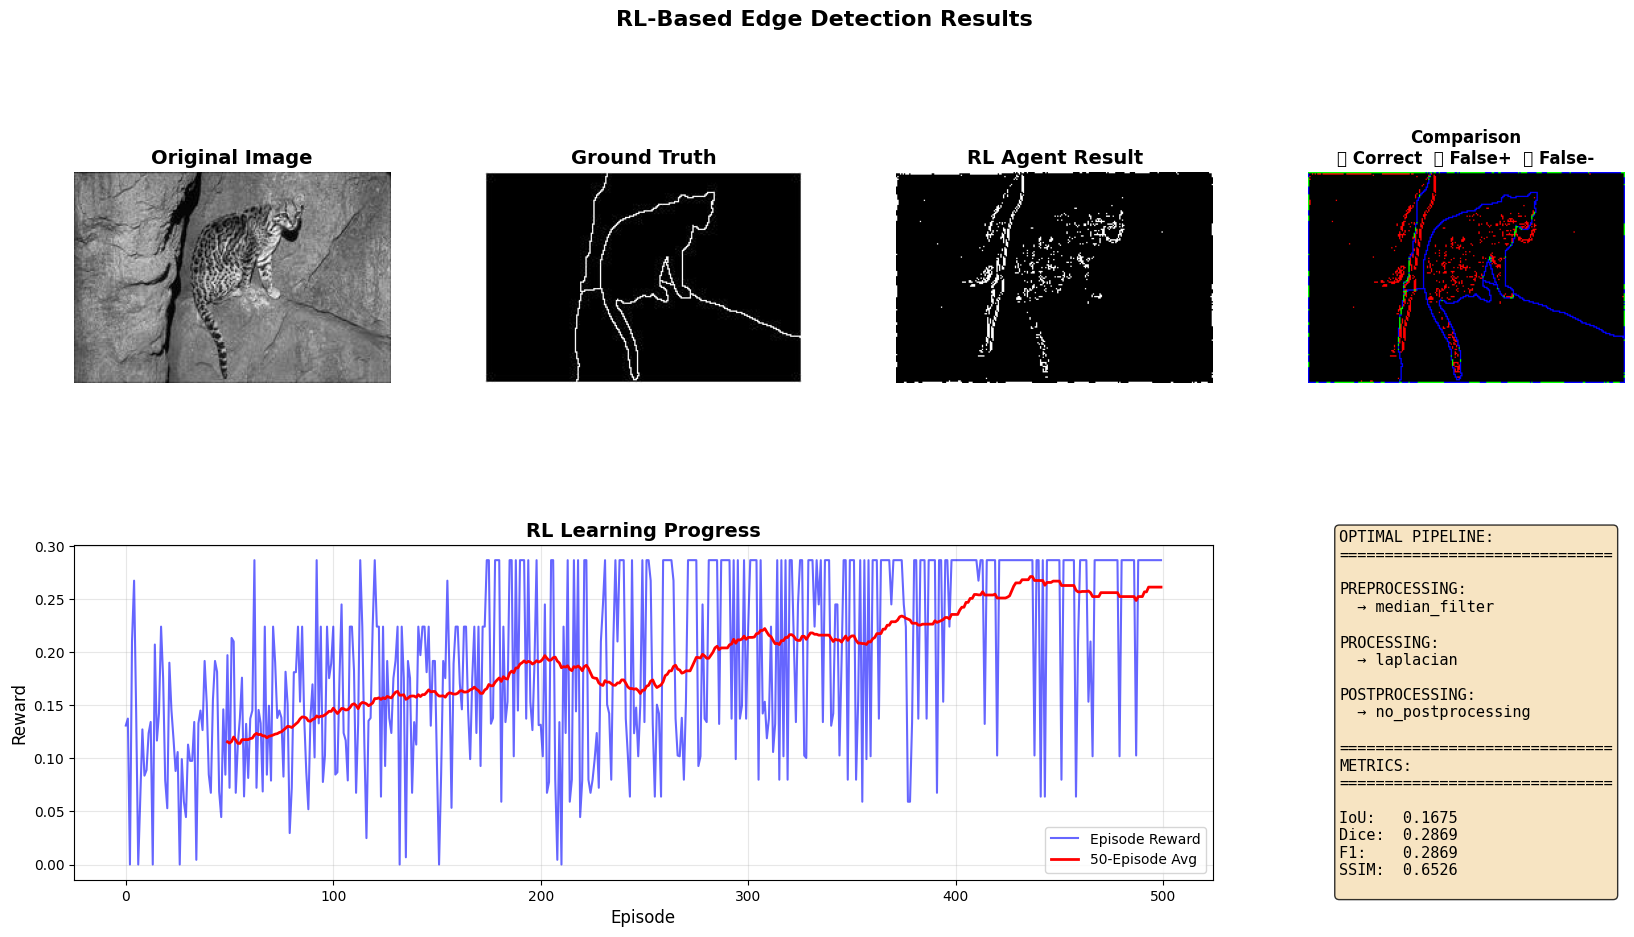

In [ ]:
"""
RL-Based Edge Detection Pipeline Optimizer - CORRECT VERSION
============================================================

Input: ONE original image + ONE ground truth
Output: Best edge detection pipeline for THAT image
"""

import numpy as np
import cv2
import pickle
from collections import defaultdict
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


# ============================================================================
# OPERATORS
# ============================================================================

class PreprocessingOperators:
    @staticmethod
    def gaussian_blur(image, kernel_size=5):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    @staticmethod
    def median_filter(image, kernel_size=5):
        return cv2.medianBlur(image, kernel_size)

    @staticmethod
    def histogram_equalization(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.equalizeHist(image)

    @staticmethod
    def bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
        return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

    @staticmethod
    def normalization(image):
        return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    @staticmethod
    def no_preprocessing(image):
        return image.copy()


class ProcessingOperators:
    @staticmethod
    def sobel(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def prewitt(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        grad_x = cv2.filter2D(image.astype(float), -1, kernel_x)
        grad_y = cv2.filter2D(image.astype(float), -1, kernel_y)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def scharr(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def laplacian(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=3)
        laplacian = np.abs(laplacian)
        laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(laplacian, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def canny(image, threshold1=50, threshold2=150):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.Canny(image, threshold1, threshold2)

    @staticmethod
    def canny_adaptive(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        median = np.median(image)
        sigma = 0.33
        lower = int(max(0, (1.0 - sigma) * median))
        upper = int(min(255, (1.0 + sigma) * median))
        return cv2.Canny(image, lower, upper)


class PostprocessingOperators:
    @staticmethod
    def dilation(image, kernel_size=3, iterations=1):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.dilate(image, kernel, iterations=iterations)

    @staticmethod
    def erosion(image, kernel_size=3, iterations=1):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.erode(image, kernel, iterations=iterations)

    @staticmethod
    def opening(image, kernel_size=3):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    @staticmethod
    def closing(image, kernel_size=3):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    @staticmethod
    def adaptive_threshold(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

    @staticmethod
    def non_maximum_suppression(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
        return gradient

    @staticmethod
    def no_postprocessing(image):
        return image.copy()


PREPROCESSING_OPS = {
    0: ('gaussian_blur', PreprocessingOperators.gaussian_blur),
    1: ('median_filter', PreprocessingOperators.median_filter),
    2: ('histogram_equalization', PreprocessingOperators.histogram_equalization),
    3: ('bilateral_filter', PreprocessingOperators.bilateral_filter),
    4: ('normalization', PreprocessingOperators.normalization),
    5: ('no_preprocessing', PreprocessingOperators.no_preprocessing),
}

PROCESSING_OPS = {
    0: ('sobel', ProcessingOperators.sobel),
    1: ('prewitt', ProcessingOperators.prewitt),
    2: ('scharr', ProcessingOperators.scharr),
    3: ('laplacian', ProcessingOperators.laplacian),
    4: ('canny', ProcessingOperators.canny),
    5: ('canny_adaptive', ProcessingOperators.canny_adaptive),
}

POSTPROCESSING_OPS = {
    0: ('dilation', PostprocessingOperators.dilation),
    1: ('erosion', PostprocessingOperators.erosion),
    2: ('opening', PostprocessingOperators.opening),
    3: ('closing', PostprocessingOperators.closing),
    4: ('adaptive_threshold', PostprocessingOperators.adaptive_threshold),
    5: ('non_maximum_suppression', PostprocessingOperators.non_maximum_suppression),
    6: ('no_postprocessing', PostprocessingOperators.no_postprocessing),
}


# ============================================================================
# METRICS
# ============================================================================

def intersection_over_union(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union if union > 0 else 0.0


def dice_coefficient(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    return 2.0 * intersection / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 0.0


def f1_score(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    true_positive = np.logical_and(pred == 1, gt == 1).sum()
    false_positive = np.logical_and(pred == 1, gt == 0).sum()
    false_negative = np.logical_and(pred == 0, gt == 1).sum()
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0


def ssim_score(pred, gt):
    if pred.shape != gt.shape:
        return 0.0
    if len(pred.shape) == 3:
        pred = pred[:, :, 0]
    if len(gt.shape) == 3:
        gt = gt[:, :, 0]
    return ssim(pred, gt, data_range=255)


def compute_reward(pred, gt, metric='iou'):
    if metric == 'iou':
        return intersection_over_union(pred, gt)
    elif metric == 'dice':
        return dice_coefficient(pred, gt)
    elif metric == 'f1':
        return f1_score(pred, gt)
    elif metric == 'ssim':
        return (ssim_score(pred, gt) + 1) / 2
    else:
        return intersection_over_union(pred, gt)


# ============================================================================
# MAIN RL FUNCTION
# ============================================================================

def find_best_pipeline(image_path, ground_truth_path, episodes=500,
                       reward_metric='iou', save_result=None):
    """
    Find the optimal edge detection pipeline for a single image using RL.

    Args:
        image_path: Path to the original image
        ground_truth_path: Path to the ground truth edge map
        episodes: Number of episodes to explore (default: 500)
        reward_metric: Metric to optimize ('iou', 'dice', 'f1', 'ssim')
        save_result: Path to save the best result (optional)

    Returns:
        Dictionary with best pipeline and results

    Example:
        result = find_best_pipeline(
            image_path='/path/to/image.jpg',
            ground_truth_path='/path/to/ground_truth.png',
            episodes=500
        )
    """

    print("\n" + "="*80)
    print("🔍 RL-BASED EDGE DETECTION - FINDING OPTIMAL PIPELINE")
    print("="*80)

    # Load images
    print(f"\n📥 Loading images...")
    print(f"   Image: {image_path}")
    print(f"   Ground truth: {ground_truth_path}")

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"❌ Could not load image: {image_path}")

    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    if ground_truth is None:
        raise ValueError(f"❌ Could not load ground truth: {ground_truth_path}")

    if image.shape != ground_truth.shape:
        ground_truth = cv2.resize(ground_truth, (image.shape[1], image.shape[0]))

    print(f"   ✓ Loaded successfully (size: {image.shape})")

    # Q-Learning setup
    print(f"\n🎯 RL Configuration:")
    print(f"   Episodes: {episodes}")
    print(f"   Reward metric: {reward_metric}")
    print(f"   Search space: {len(PREPROCESSING_OPS)} × {len(PROCESSING_OPS)} × {len(POSTPROCESSING_OPS)} = {len(PREPROCESSING_OPS) * len(PROCESSING_OPS) * len(POSTPROCESSING_OPS)} combinations")

    q_table = defaultdict(lambda: defaultdict(float))
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    learning_rate = 0.1
    discount_factor = 0.95

    best_reward = -float('inf')
    best_pipeline = None
    best_result = None
    history = []

    print(f"\n🚀 Starting exploration...")
    print("-"*80)

    # RL exploration
    for episode in range(episodes):
        # Reset
        current_img = image.copy()
        pipeline = {}
        total_reward = 0

        # Phase 1: Preprocessing
        state = 0
        if np.random.random() < epsilon:
            action = np.random.randint(0, len(PREPROCESSING_OPS))
        else:
            q_values = [q_table[state][a] for a in range(len(PREPROCESSING_OPS))]
            action = np.argmax(q_values)

        op_name, op_func = PREPROCESSING_OPS[action]
        current_img = op_func(current_img)
        pipeline['preprocessing'] = (action, op_name)

        # Phase 2: Processing (Edge Detection)
        state = 1
        if np.random.random() < epsilon:
            action = np.random.randint(0, len(PROCESSING_OPS))
        else:
            q_values = [q_table[state][a] for a in range(len(PROCESSING_OPS))]
            action = np.argmax(q_values)

        op_name, op_func = PROCESSING_OPS[action]
        current_img = op_func(current_img)
        pipeline['processing'] = (action, op_name)

        # Phase 3: Postprocessing
        state = 2
        if np.random.random() < epsilon:
            action = np.random.randint(0, len(POSTPROCESSING_OPS))
        else:
            q_values = [q_table[state][a] for a in range(len(POSTPROCESSING_OPS))]
            action = np.argmax(q_values)

        op_name, op_func = POSTPROCESSING_OPS[action]
        current_img = op_func(current_img)
        pipeline['postprocessing'] = (action, op_name)

        # Compute reward
        reward = compute_reward(current_img, ground_truth, metric=reward_metric)

        # Update Q-values
        for phase_idx, phase_name in enumerate(['preprocessing', 'processing', 'postprocessing']):
            action_taken = pipeline[phase_name][0]
            q_table[phase_idx][action_taken] = q_table[phase_idx][action_taken] + \
                learning_rate * (reward - q_table[phase_idx][action_taken])

        # Track best
        if reward > best_reward:
            best_reward = reward
            best_pipeline = pipeline.copy()
            best_result = current_img.copy()

        history.append(reward)

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(history[-100:])
            print(f"   Episode {episode + 1:4d}/{episodes} | "
                  f"Avg Reward: {avg_reward:.4f} | "
                  f"Best Reward: {best_reward:.4f} | "
                  f"Epsilon: {epsilon:.4f}")

    print("-"*80)
    print("✅ Exploration completed!\n")

    # Compute final metrics
    metrics = {
        'iou': intersection_over_union(best_result, ground_truth),
        'dice': dice_coefficient(best_result, ground_truth),
        'f1': f1_score(best_result, ground_truth),
        'ssim': ssim_score(best_result, ground_truth),
    }

    print("="*80)
    print("📊 BEST PIPELINE FOUND")
    print("="*80)
    print(f"\n🔧 Optimal Pipeline:")
    for phase, (idx, name) in best_pipeline.items():
        print(f"   {phase.capitalize():15s} → {name}")

    print(f"\n📈 Performance Metrics:")
    print(f"   IoU:        {metrics['iou']:.4f}")
    print(f"   Dice:       {metrics['dice']:.4f}")
    print(f"   F1 Score:   {metrics['f1']:.4f}")
    print(f"   SSIM:       {metrics['ssim']:.4f}")
    print("="*80 + "\n")

    # Save result
    if save_result:
        cv2.imwrite(save_result, best_result)
        print(f"💾 Result saved to: {save_result}\n")

    # Visualize
    visualize_comparison(image, ground_truth, best_result, metrics, best_pipeline, history)

    return {
        'pipeline': best_pipeline,
        'result': best_result,
        'metrics': metrics,
        'reward_history': history,
        'best_reward': best_reward
    }


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_comparison(original, ground_truth, predicted, metrics, pipeline, history):
    """Create comprehensive visualization"""
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

    # Row 1: Images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(ground_truth, cmap='gray')
    ax2.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(predicted, cmap='gray')
    ax3.set_title('RL Agent Result', fontsize=14, fontweight='bold')
    ax3.axis('off')

    # Comparison overlay
    gt_binary = (ground_truth > 127).astype(np.uint8)
    pred_binary = (predicted > 127).astype(np.uint8)
    overlay = np.zeros((*original.shape, 3), dtype=np.uint8)
    overlay[..., 1] = np.logical_and(pred_binary, gt_binary).astype(np.uint8) * 255  # Green
    overlay[..., 0] = np.logical_and(pred_binary, ~gt_binary.astype(bool)).astype(np.uint8) * 255  # Red
    overlay[..., 2] = np.logical_and(~pred_binary.astype(bool), gt_binary).astype(np.uint8) * 255  # Blue

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(overlay)
    ax4.set_title('Comparison\n🟢 Correct  🔴 False+  🔵 False-', fontsize=12, fontweight='bold')
    ax4.axis('off')

    # Row 2: Learning curve and metrics
    ax5 = fig.add_subplot(gs[1, :3])
    episodes = list(range(len(history)))
    ax5.plot(episodes, history, alpha=0.6, color='blue', label='Episode Reward')

    # Moving average
    window = 50
    if len(history) >= window:
        moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
        ax5.plot(episodes[window-1:], moving_avg, 'r-', linewidth=2, label=f'{window}-Episode Avg')

    ax5.set_xlabel('Episode', fontsize=12)
    ax5.set_ylabel('Reward', fontsize=12)
    ax5.set_title('RL Learning Progress', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Pipeline and metrics info
    ax6 = fig.add_subplot(gs[1, 3])
    ax6.axis('off')

    info_text = "OPTIMAL PIPELINE:\n" + "="*30 + "\n\n"
    for phase, (idx, name) in pipeline.items():
        info_text += f"{phase.upper()}:\n  → {name}\n\n"

    info_text += "="*30 + "\n"
    info_text += "METRICS:\n" + "="*30 + "\n\n"
    info_text += f"IoU:   {metrics['iou']:.4f}\n"
    info_text += f"Dice:  {metrics['dice']:.4f}\n"
    info_text += f"F1:    {metrics['f1']:.4f}\n"
    info_text += f"SSIM:  {metrics['ssim']:.4f}\n"

    ax6.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.suptitle('RL-Based Edge Detection Results', fontsize=16, fontweight='bold', y=0.98)
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":


 result = find_best_pipeline(
    image_path='/content/test/xhettah.jpeg',
    ground_truth_path='/content/gt/chetah.jpg',
    episodes=500,
    reward_metric='f1',
    save_result='best_result.png'
)




🔍 IMPROVED RL EDGE DETECTION - FINDING OPTIMAL PIPELINE

📥 Loading images...
   Image: /content/test/airplaitest.jpeg
   Ground truth: /content/gt/airplane.jpg
   ✓ Loaded successfully (size: (321, 481))

🎯 IMPROVED RL Configuration:
   Episodes: 500
   Reward metric: iou
   Search space: 11 × 10 × 11 = 1210 combinations
   🆕 Enhanced operators for texture handling!

🚀 Starting exploration...
--------------------------------------------------------------------------------
   🎉 New best at episode 1: 0.3033
       Pipeline: median_filter → sobel_strong_threshold → remove_small_objects
   🎉 New best at episode 2: 0.3381
       Pipeline: gaussian_blur → sobel_strong_threshold → close_gaps
   🎉 New best at episode 32: 0.3546
       Pipeline: gaussian_blur → sobel_strong_threshold → remove_small_objects
   Episode  200/500 | Avg Reward: 0.2160 | Best: 0.3546 | Epsilon: 0.3670
   🎉 New best at episode 346: 0.3885
       Pipeline: histogram_equalization → sobel → close_gaps
   Episode  400/5

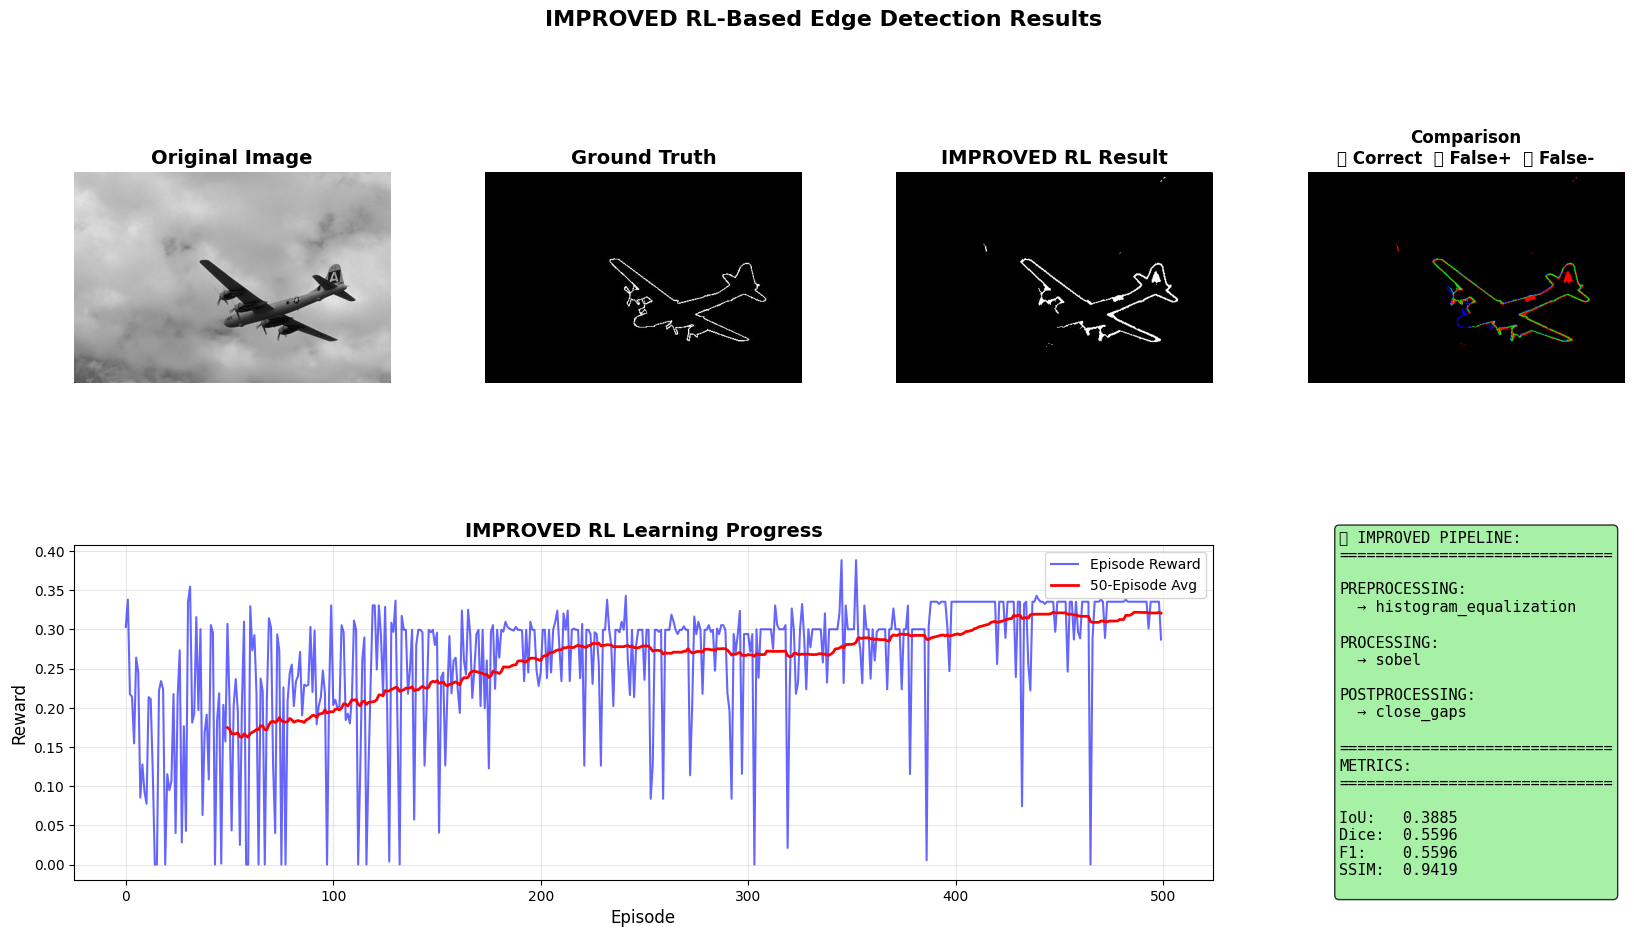

In [ ]:
"""
IMPROVED RL-Based Edge Detection Pipeline
==========================================

Enhanced with:
- Advanced filtering operators
- Contour-based methods
- Multi-scale processing
- Better morphological operations
- Adaptive techniques
"""

import numpy as np
import cv2
import pickle
from collections import defaultdict
from skimage.metrics import structural_similarity as ssim
from skimage import morphology
from scipy import ndimage
import matplotlib.pyplot as plt


# ============================================================================
# ENHANCED OPERATORS
# ============================================================================

class PreprocessingOperators:
    """Phase 1: Enhanced Preprocessing"""

    @staticmethod
    def gaussian_blur(image, kernel_size=5):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    @staticmethod
    def gaussian_blur_strong(image, kernel_size=9):
        """Strong blur to remove texture"""
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    @staticmethod
    def median_filter(image, kernel_size=5):
        return cv2.medianBlur(image, kernel_size)

    @staticmethod
    def median_filter_strong(image, kernel_size=9):
        """Strong median filter for texture"""
        return cv2.medianBlur(image, kernel_size)

    @staticmethod
    def bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
        """Preserve edges while smoothing"""
        return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

    @staticmethod
    def bilateral_filter_strong(image, d=15, sigma_color=100, sigma_space=100):
        """Strong bilateral for texture removal"""
        return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

    @staticmethod
    def morphological_opening(image, kernel_size=3):
        """Remove small bright spots"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    @staticmethod
    def morphological_closing(image, kernel_size=3):
        """Remove small dark spots"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    @staticmethod
    def histogram_equalization(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.equalizeHist(image)

    @staticmethod
    def clahe(image):
        """Contrast Limited Adaptive Histogram Equalization"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image)

    @staticmethod
    def no_preprocessing(image):
        return image.copy()


class ProcessingOperators:
    """Phase 2: Enhanced Edge Detection"""

    @staticmethod
    def sobel(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def sobel_strong_threshold(image):
        """Sobel with higher threshold to reduce noise"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 100, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def scharr(image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def scharr_strong_threshold(image):
        """Scharr with higher threshold"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
        gradient = np.sqrt(grad_x**2 + grad_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(gradient, 100, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def canny(image, threshold1=50, threshold2=150):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.Canny(image, threshold1, threshold2)

    @staticmethod
    def canny_adaptive(image):
        """Adaptive Canny"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        median = np.median(image)
        sigma = 0.33
        lower = int(max(0, (1.0 - sigma) * median))
        upper = int(min(255, (1.0 + sigma) * median))
        return cv2.Canny(image, lower, upper)

    @staticmethod
    def canny_strict(image):
        """Canny with strict thresholds for strong edges only"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.Canny(image, 100, 200)

    @staticmethod
    def morphological_gradient(image):
        """Morphological gradient - good for object boundaries"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
        _, binary = cv2.threshold(gradient, 30, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def morphological_gradient_strong(image):
        """Stronger morphological gradient"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
        _, binary = cv2.threshold(gradient, 50, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def laplacian_weak(image):
        """Laplacian with strong threshold to reduce texture"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=3)
        laplacian = np.abs(laplacian)
        laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, binary = cv2.threshold(laplacian, 80, 255, cv2.THRESH_BINARY)
        return binary


class PostprocessingOperators:
    """Phase 3: Enhanced Post-processing"""

    @staticmethod
    def skeletonize(image):
        """Thin edges to single-pixel lines"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        binary = (image > 127).astype(np.uint8)
        skeleton = morphology.skeletonize(binary)
        return (skeleton * 255).astype(np.uint8)

    @staticmethod
    def thin_edges(image):
        """Morphological thinning"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3, 3), np.uint8)
        thinned = cv2.morphologyEx(image, cv2.MORPH_ERODE, kernel, iterations=1)
        return thinned

    @staticmethod
    def close_gaps(image):
        """Close small gaps in edges"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
        return closed

    @staticmethod
    def close_gaps_strong(image):
        """Close larger gaps"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
        return closed

    @staticmethod
    def remove_small_objects(image, min_size=50):
        """Remove small disconnected edge fragments"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        binary = (image > 127).astype(bool)
        cleaned = morphology.remove_small_objects(binary, min_size=min_size)
        return (cleaned * 255).astype(np.uint8)

    @staticmethod
    def remove_small_objects_aggressive(image, min_size=100):
        """Aggressively remove small objects"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        binary = (image > 127).astype(bool)
        cleaned = morphology.remove_small_objects(binary, min_size=min_size)
        return (cleaned * 255).astype(np.uint8)

    @staticmethod
    def contour_filter_large(image):
        """Keep only large contours (main objects)"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            return image

        # Keep contours larger than 20% of largest
        areas = [cv2.contourArea(c) for c in contours]
        max_area = max(areas) if areas else 0

        result = np.zeros_like(image)
        for contour, area in zip(contours, areas):
            if area > max_area * 0.2:
                cv2.drawContours(result, [contour], -1, 255, 1)

        return result

    @staticmethod
    def contour_filter_smooth(image):
        """Smooth and filter contours"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        result = np.zeros_like(image)
        for contour in contours:
            # Approximate contour to smooth it
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            cv2.drawContours(result, [approx], -1, 255, 1)

        return result

    @staticmethod
    def opening(image, kernel_size=3):
        """Remove small protrusions"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    @staticmethod
    def opening_strong(image, kernel_size=5):
        """Strong opening"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    @staticmethod
    def no_postprocessing(image):
        return image.copy()


# Operator registries
PREPROCESSING_OPS = {
    0: ('gaussian_blur', PreprocessingOperators.gaussian_blur),
    1: ('gaussian_blur_strong', PreprocessingOperators.gaussian_blur_strong),
    2: ('median_filter', PreprocessingOperators.median_filter),
    3: ('median_filter_strong', PreprocessingOperators.median_filter_strong),
    4: ('bilateral_filter', PreprocessingOperators.bilateral_filter),
    5: ('bilateral_filter_strong', PreprocessingOperators.bilateral_filter_strong),
    6: ('morphological_opening', PreprocessingOperators.morphological_opening),
    7: ('morphological_closing', PreprocessingOperators.morphological_closing),
    8: ('histogram_equalization', PreprocessingOperators.histogram_equalization),
    9: ('clahe', PreprocessingOperators.clahe),
    10: ('no_preprocessing', PreprocessingOperators.no_preprocessing),
}

PROCESSING_OPS = {
    0: ('sobel', ProcessingOperators.sobel),
    1: ('sobel_strong_threshold', ProcessingOperators.sobel_strong_threshold),
    2: ('scharr', ProcessingOperators.scharr),
    3: ('scharr_strong_threshold', ProcessingOperators.scharr_strong_threshold),
    4: ('canny', ProcessingOperators.canny),
    5: ('canny_adaptive', ProcessingOperators.canny_adaptive),
    6: ('canny_strict', ProcessingOperators.canny_strict),
    7: ('morphological_gradient', ProcessingOperators.morphological_gradient),
    8: ('morphological_gradient_strong', ProcessingOperators.morphological_gradient_strong),
    9: ('laplacian_weak', ProcessingOperators.laplacian_weak),
}

POSTPROCESSING_OPS = {
    0: ('skeletonize', PostprocessingOperators.skeletonize),
    1: ('thin_edges', PostprocessingOperators.thin_edges),
    2: ('close_gaps', PostprocessingOperators.close_gaps),
    3: ('close_gaps_strong', PostprocessingOperators.close_gaps_strong),
    4: ('remove_small_objects', PostprocessingOperators.remove_small_objects),
    5: ('remove_small_objects_aggressive', PostprocessingOperators.remove_small_objects_aggressive),
    6: ('contour_filter_large', PostprocessingOperators.contour_filter_large),
    7: ('contour_filter_smooth', PostprocessingOperators.contour_filter_smooth),
    8: ('opening', PostprocessingOperators.opening),
    9: ('opening_strong', PostprocessingOperators.opening_strong),
    10: ('no_postprocessing', PostprocessingOperators.no_postprocessing),
}


# ============================================================================
# METRICS (Same as before)
# ============================================================================

def intersection_over_union(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union if union > 0 else 0.0


def dice_coefficient(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    intersection = np.logical_and(pred, gt).sum()
    return 2.0 * intersection / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 0.0


def f1_score(pred, gt):
    pred = (pred > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)
    true_positive = np.logical_and(pred == 1, gt == 1).sum()
    false_positive = np.logical_and(pred == 1, gt == 0).sum()
    false_negative = np.logical_and(pred == 0, gt == 1).sum()
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0


def ssim_score(pred, gt):
    if pred.shape != gt.shape:
        return 0.0
    if len(pred.shape) == 3:
        pred = pred[:, :, 0]
    if len(gt.shape) == 3:
        gt = gt[:, :, 0]
    return ssim(pred, gt, data_range=255)


def compute_reward(pred, gt, metric='iou'):
    if metric == 'iou':
        return intersection_over_union(pred, gt)
    elif metric == 'dice':
        return dice_coefficient(pred, gt)
    elif metric == 'f1':
        return f1_score(pred, gt)
    elif metric == 'ssim':
        return (ssim_score(pred, gt) + 1) / 2
    else:
        return intersection_over_union(pred, gt)


# ============================================================================
# IMPROVED RL FUNCTION
# ============================================================================

def find_best_pipeline(image_path, ground_truth_path, episodes=1000,
                       reward_metric='iou', save_result=None):
    """
    IMPROVED: Find optimal pipeline with enhanced operators.

    Now searches: 11 × 10 × 11 = 1,210 combinations!
    """

    print("\n" + "="*80)
    print("🔍 IMPROVED RL EDGE DETECTION - FINDING OPTIMAL PIPELINE")
    print("="*80)

    # Load images
    print(f"\n📥 Loading images...")
    print(f"   Image: {image_path}")
    print(f"   Ground truth: {ground_truth_path}")

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"❌ Could not load image: {image_path}")

    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    if ground_truth is None:
        raise ValueError(f"❌ Could not load ground truth: {ground_truth_path}")

    if image.shape != ground_truth.shape:
        ground_truth = cv2.resize(ground_truth, (image.shape[1], image.shape[0]))

    print(f"   ✓ Loaded successfully (size: {image.shape})")

    # Q-Learning setup
    print(f"\n🎯 IMPROVED RL Configuration:")
    print(f"   Episodes: {episodes}")
    print(f"   Reward metric: {reward_metric}")
    print(f"   Search space: {len(PREPROCESSING_OPS)} × {len(PROCESSING_OPS)} × {len(POSTPROCESSING_OPS)} = {len(PREPROCESSING_OPS) * len(PROCESSING_OPS) * len(POSTPROCESSING_OPS)} combinations")
    print(f"   🆕 Enhanced operators for texture handling!")

    q_table = defaultdict(lambda: defaultdict(float))
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    learning_rate = 0.15  # Slightly higher learning rate
    discount_factor = 0.95

    best_reward = -float('inf')
    best_pipeline = None
    best_result = None
    history = []

    print(f"\n🚀 Starting exploration...")
    print("-"*80)

    # RL exploration
    for episode in range(episodes):
        try:
            # Reset
            current_img = image.copy()
            pipeline = {}

            # Phase 1: Preprocessing
            state = 0
            if np.random.random() < epsilon:
                action = np.random.randint(0, len(PREPROCESSING_OPS))
            else:
                q_values = [q_table[state][a] for a in range(len(PREPROCESSING_OPS))]
                action = np.argmax(q_values) if any(q_values) else np.random.randint(0, len(PREPROCESSING_OPS))

            op_name, op_func = PREPROCESSING_OPS[action]
            current_img = op_func(current_img)
            pipeline['preprocessing'] = (action, op_name)

            # Phase 2: Processing
            state = 1
            if np.random.random() < epsilon:
                action = np.random.randint(0, len(PROCESSING_OPS))
            else:
                q_values = [q_table[state][a] for a in range(len(PROCESSING_OPS))]
                action = np.argmax(q_values) if any(q_values) else np.random.randint(0, len(PROCESSING_OPS))

            op_name, op_func = PROCESSING_OPS[action]
            current_img = op_func(current_img)
            pipeline['processing'] = (action, op_name)

            # Phase 3: Postprocessing
            state = 2
            if np.random.random() < epsilon:
                action = np.random.randint(0, len(POSTPROCESSING_OPS))
            else:
                q_values = [q_table[state][a] for a in range(len(POSTPROCESSING_OPS))]
                action = np.argmax(q_values) if any(q_values) else np.random.randint(0, len(POSTPROCESSING_OPS))

            op_name, op_func = POSTPROCESSING_OPS[action]
            current_img = op_func(current_img)
            pipeline['postprocessing'] = (action, op_name)

            # Compute reward
            reward = compute_reward(current_img, ground_truth, metric=reward_metric)

            # Update Q-values
            for phase_idx, phase_name in enumerate(['preprocessing', 'processing', 'postprocessing']):
                action_taken = pipeline[phase_name][0]
                q_table[phase_idx][action_taken] = q_table[phase_idx][action_taken] + \
                    learning_rate * (reward - q_table[phase_idx][action_taken])

            # Track best
            if reward > best_reward:
                best_reward = reward
                best_pipeline = pipeline.copy()
                best_result = current_img.copy()
                print(f"   🎉 New best at episode {episode + 1}: {best_reward:.4f}")
                print(f"       Pipeline: {pipeline['preprocessing'][1]} → {pipeline['processing'][1]} → {pipeline['postprocessing'][1]}")

            history.append(reward)

        except Exception as e:
            # Skip failed combinations
            history.append(0)
            continue

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Progress
        if (episode + 1) % 200 == 0:
            avg_reward = np.mean(history[-200:])
            print(f"   Episode {episode + 1:4d}/{episodes} | "
                  f"Avg Reward: {avg_reward:.4f} | "
                  f"Best: {best_reward:.4f} | "
                  f"Epsilon: {epsilon:.4f}")

    print("-"*80)
    print("✅ Exploration completed!\n")

    # Compute final metrics
    metrics = {
        'iou': intersection_over_union(best_result, ground_truth),
        'dice': dice_coefficient(best_result, ground_truth),
        'f1': f1_score(best_result, ground_truth),
        'ssim': ssim_score(best_result, ground_truth),
    }

    print("="*80)
    print("📊 BEST PIPELINE FOUND")
    print("="*80)
    print(f"\n🔧 Optimal Pipeline:")
    for phase, (idx, name) in best_pipeline.items():
        print(f"   {phase.capitalize():15s} → {name}")

    print(f"\n📈 Performance Metrics:")
    print(f"   IoU:        {metrics['iou']:.4f}")
    print(f"   Dice:       {metrics['dice']:.4f}")
    print(f"   F1 Score:   {metrics['f1']:.4f}")
    print(f"   SSIM:       {metrics['ssim']:.4f}")
    print("="*80 + "\n")

    # Save result
    if save_result:
        cv2.imwrite(save_result, best_result)
        print(f"💾 Result saved to: {save_result}\n")

    # Visualize
    visualize_comparison(image, ground_truth, best_result, metrics, best_pipeline, history)

    return {
        'pipeline': best_pipeline,
        'result': best_result,
        'metrics': metrics,
        'reward_history': history,
        'best_reward': best_reward
    }


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_comparison(original, ground_truth, predicted, metrics, pipeline, history):
    """Create comprehensive visualization"""
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

    # Row 1: Images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(ground_truth, cmap='gray')
    ax2.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(predicted, cmap='gray')
    ax3.set_title('IMPROVED RL Result', fontsize=14, fontweight='bold')
    ax3.axis('off')

    # Comparison overlay
    gt_binary = (ground_truth > 127).astype(np.uint8)
    pred_binary = (predicted > 127).astype(np.uint8)
    overlay = np.zeros((*original.shape, 3), dtype=np.uint8)
    overlay[..., 1] = np.logical_and(pred_binary, gt_binary).astype(np.uint8) * 255
    overlay[..., 0] = np.logical_and(pred_binary, ~gt_binary.astype(bool)).astype(np.uint8) * 255
    overlay[..., 2] = np.logical_and(~pred_binary.astype(bool), gt_binary).astype(np.uint8) * 255

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(overlay)
    ax4.set_title('Comparison\n🟢 Correct  🔴 False+  🔵 False-', fontsize=12, fontweight='bold')
    ax4.axis('off')

    # Row 2: Learning curve
    ax5 = fig.add_subplot(gs[1, :3])
    episodes = list(range(len(history)))
    ax5.plot(episodes, history, alpha=0.6, color='blue', label='Episode Reward')

    window = 50
    if len(history) >= window:
        moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
        ax5.plot(episodes[window-1:], moving_avg, 'r-', linewidth=2, label=f'{window}-Episode Avg')

    ax5.set_xlabel('Episode', fontsize=12)
    ax5.set_ylabel('Reward', fontsize=12)
    ax5.set_title('IMPROVED RL Learning Progress', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Pipeline info
    ax6 = fig.add_subplot(gs[1, 3])
    ax6.axis('off')

    info_text = "🆕 IMPROVED PIPELINE:\n" + "="*30 + "\n\n"
    for phase, (idx, name) in pipeline.items():
        info_text += f"{phase.upper()}:\n  → {name}\n\n"

    info_text += "="*30 + "\n"
    info_text += "METRICS:\n" + "="*30 + "\n\n"
    info_text += f"IoU:   {metrics['iou']:.4f}\n"
    info_text += f"Dice:  {metrics['dice']:.4f}\n"
    info_text += f"F1:    {metrics['f1']:.4f}\n"
    info_text += f"SSIM:  {metrics['ssim']:.4f}\n"

    ax6.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    plt.suptitle('IMPROVED RL-Based Edge Detection Results', fontsize=16, fontweight='bold', y=0.98)
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":



 result = find_best_pipeline(
    image_path='/content/test/airplaitest.jpeg',
    ground_truth_path='/content/gt/airplane.jpg',
    episodes=500,
    reward_metric='iou',
    save_result='best_result.png'
)
